## Import packages

In [14]:
import osmnx as ox, networkx as nx, numpy as np, pandas as pd, geopandas as gpd, random, math
import matplotlib.pyplot as plt, matplotlib.colors as mcolors
from shapely.geometry import Point
from shapely.ops import transform
from scipy.spatial import cKDTree
from itertools import cycle
from pathlib import Path
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import pyproj
import folium
from folium import GeoJson, CircleMarker, Marker, PolyLine, Icon, DivIcon
from folium.plugins import MarkerCluster
from matplotlib.lines import Line2D

## Load data

In [15]:
def cargar_geojson(nombre_archivo, directorio_base='../../../../data/delivetter'):
    """
    Carga un archivo GeoJSON específico y devuelve un GeoDataFrame.
    
    Args:
        nombre_archivo (str): Nombre del archivo GeoJSON (ej. 'barris.geojson').
        directorio_base (str): Ruta relativa al directorio donde se encuentra el archivo.
                              Por defecto: '../../data/delivetter'.
    
    Returns:
        gpd.GeoDataFrame: GeoDataFrame con los datos del archivo.
        None: Si el archivo no existe o hay un error.
    """
    try:
        ruta = Path(directorio_base) / nombre_archivo
        
        if not ruta.exists():
            raise FileNotFoundError(f"Archivo no encontrado: {ruta.absolute()}")
        
        gdf = gpd.read_file(ruta)
        print(f"✅ '{nombre_archivo}' cargado correctamente ({len(gdf)} registros)")
        return gdf
    
    except Exception as e:
        print(f"❌ Error al cargar '{nombre_archivo}': {str(e)}")
        return None
    
barrios = cargar_geojson('barris.geojson')
catastro = cargar_geojson('catastro.geojson')
puntos_carga = cargar_geojson('puntosCID.geojson')

✅ 'barris.geojson' cargado correctamente (88 registros)
✅ 'catastro.geojson' cargado correctamente (36346 registros)
✅ 'puntosCID.geojson' cargado correctamente (885 registros)


## Graph request and data integration

In [16]:
def get_graph(request):
    shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    while len(shp_neighbourhood) != 1:
        request = input("Please, introduce a valid neighbourhood: ")
        shp_neighbourhood = barrios[barrios["nombre"].str.upper().str.contains(request.strip().upper())]
    shp_zone = shp_neighbourhood["geometry"].values[0]
    shp_loading_points = puntos_carga[puntos_carga.intersects(shp_zone)]
    shp_bajos = catastro[catastro.intersects(shp_zone)]

    G = ox.graph_from_polygon(shp_zone, 
                              network_type="all_public",  
                              simplify=False, 
                              retain_all=False,  
                              truncate_by_edge=True) 
    not_highway = ['elevator', 'busway', 'corridor', 'unclassified', 'services', 'cycleway', 'steps', 'service']

    allowed_vehicle = ['motorway', 'residential', 'secondary', 'living_street',
                    'primary_link', 'primary', 'tertiary', 'trunk', 'service',
                    'tertiary_link', 'trunk_link', 'secondary_link', 'motorway_link', 'road']
    
    allowed_pedestrian = ["pedestrian", "footway", "path", "track", "bridleway", "living_street", "residential"]
    edges_to_remove = [(u, v, k) for u, v, k, data in G.edges(keys=True, data=True) 
                   if data.get('highway') in not_highway or data.get('access') in ['private', 'no', 'customers']]
    G.remove_edges_from(edges_to_remove)

    G_vehicle = G.copy()  
    edges_to_remove_vehicle = [(u, v, k) for u, v, k, data in G_vehicle.edges(keys=True, data=True) 
                                   if data.get('highway') not in allowed_vehicle]
    G_vehicle.remove_edges_from(edges_to_remove_vehicle)
    
    G_pedestrian = G.copy()  
    edges_to_remove_pedestrian = [(u, v, k) for u, v, k, data in G_pedestrian.edges(keys=True, data=True) 
                                      if data.get('highway') not in allowed_pedestrian]
    G_pedestrian.remove_edges_from(edges_to_remove_pedestrian)

    for graph in [G_vehicle, G_pedestrian]:
        nodes_to_remove = [node for node in graph.nodes if graph.degree(node) == 0]
        graph.remove_nodes_from(nodes_to_remove)

    for u, v, k, data in G_pedestrian.edges(keys=True, data=True):
        data['oneway'] = False

    G_vehicle = G_vehicle.subgraph(max(nx.weakly_connected_components(G_vehicle), key=len)).copy()
    G_pedestrian = G_pedestrian.subgraph(max(nx.weakly_connected_components(G_pedestrian), key=len)).copy()


    print(f"Vehicle graph: {len(G_vehicle.nodes)} nodes, {len(G_vehicle.edges)} edges")
    print(f"Pedestrian graph: {len(G_pedestrian.nodes)} nodes, {len(G_pedestrian.edges)} edges")
    

    # Figura para el grafo de vehículos
    fig1, ax1 = plt.subplots(figsize=(20, 7))
    ax1.set_title("Drive graph")
    ox.plot_graph(G_vehicle, ax=ax1, node_size=3, node_color='green', 
                edge_linewidth=0.5, edge_color='blue', bgcolor="white", show=False)
    plt.show()

    # Figura para el grafo de peatones
    fig2, ax2 = plt.subplots(figsize=(20, 7))
    ax2.set_title("Pedestrian graph")
    ox.plot_graph(G_pedestrian, ax=ax2, node_size=3, node_color='green', 
                edge_linewidth=0.5, edge_color='red', bgcolor="white", show=False)
    plt.show()

    
    

    return G_vehicle, G_pedestrian, shp_zone, shp_loading_points, shp_bajos
    


def graph_map(G_vehicle, G_pedestrian, shp_zone, shp_loading_points, bajos):
    mapa = folium.Map(location=[shp_zone.centroid.y, shp_zone.centroid.x], zoom_start=16)

    gdf_edges_vehicle = ox.graph_to_gdfs(G_vehicle, nodes=False, edges=True)
    gdf_edges_pedestrian = ox.graph_to_gdfs(G_pedestrian, nodes=False, edges=True)

    bajos_in_zone = bajos[bajos.intersects(shp_zone)]

    folium.GeoJson(
        shp_zone,  
        style_function=lambda feature: {
            "color": "green", 
            "weight": 6,  
            "fill": True,  
            "fillColor": "limegreen",  
            "fillOpacity": 0.2  
        }
    ).add_to(mapa)
    
    def add_edges_with_popup(gdf_edges, color, group_name):
        for _, row in gdf_edges.iterrows():
            if row["geometry"].geom_type == "LineString":
                popup_text = f"<b>Tipo:</b> {row.get('highway', 'N/A')}<br>"
                popup_text += f"<b>Nombre:</b> {row.get('name', 'Sin nombre')}<br>"
                popup_text += f"<b>Longitud:</b> {round(row.get('length', 0), 1)} m"

                folium.GeoJson(
                    row["geometry"],
                    name=group_name,
                    style_function=lambda feature, col=color: {
                        'color': col,
                        'weight': 2,
                        'opacity': 1
                    },
                    tooltip=popup_text
                ).add_to(mapa)
    add_edges_with_popup(gdf_edges_pedestrian, "red", "Peatones")
    add_edges_with_popup(gdf_edges_vehicle, "blue", "Vehículos")
    

    

    shp_loading_points.apply(lambda row: folium.CircleMarker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x], 
        radius=6,  
        color="black",  
        fill=True,
        fill_color="orange",  
        fill_opacity=1, 
        popup=row.get("NOMBRE", "Punto de carga")
    ).add_to(mapa), axis=1)

    # Puntos bajos
    for _, row in bajos_in_zone.iterrows():
        if not row['Almacen'] and not row['Comercio']:
            continue

        centroide = row.geometry.centroid
        if row['Almacen'] and row['Comercio']:
            fill_color = 'black'
            tipo = "Almacén y Comercio"
        elif row['Almacen']:
            fill_color = 'purple'
            tipo = "Almacén"
        elif row['Comercio']:
            fill_color = 'lightblue'
            tipo = "Comercio"

        folium.CircleMarker(
            location=[centroide.y, centroide.x],
            radius=6,
            color='black',
            fill=True,
            fill_color=fill_color,
            fill_opacity=1,
            popup=tipo
        ).add_to(mapa)

    legend_html = '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 250px; height: 130px; 
                            background-color: white; z-index:9999; font-size:13px;
                            border:1px solid grey; border-radius: 5px; padding: 8px;
                            box-shadow: 2px 2px 5px rgba(0,0,0,0.2);">
                    <b style="font-size:14px;">Legend</b> <br>
                    <i class="fa fa-circle" style="color:black; margin-right:5px;"></i> Warehouse & Store <br>
                    <i class="fa fa-circle" style="color:orange; margin-right:5px;"></i> CiD Point <br>
                    <i class="fa fa-circle" style="color:purple; margin-right:5px;"></i> Warehouse <br>
                    <i class="fa fa-circle" style="color:lightblue; margin-right:5px;"></i> Store (delivery point) <br>
                    <i class="fa fa-square" style="color:limegreen; margin-right:5px;"></i> Neigborhood boundary
                </div>
                '''

    mapa.get_root().html.add_child(folium.Element(legend_html))
    
    return mapa




| FAVARA               | BENICALAP             | SANT PAU                 | BORBOTO                  | BENIFARAIG               |
|----------------------|----------------------|--------------------------|--------------------------|--------------------------|
| CAMI REAL           | JAUME ROIG            | LA SEU                   | AIORA                    | TORMOS                   |
| LA FONTETA S.LLUIS  | LA PETXINA            | L'HORT DE SENABRE        | CIUTAT JARDI             | CAMI DE VERA             |
| LA PUNTA            | SANT MARCEL.LI        | FAITANAR                 | PINEDO                   | CASTELLAR-L'OLIVERAL     |
| BENIMAMET           | EL FORN D'ALCEDO      | MONTOLIVET               | CIUTAT DE LES ARTS I DE LES CIENCIES | NA ROVELLA             |
| SANT LLORENS        | NATZARET              | LA CREU COBERTA          | L'AMISTAT                | EL GRAU                  |
| CIUTAT FALLERA      | RAFALELL-VISTABELLA   | LA CARRASCA              | BENIFERRI                | EL SALER                 |
| NOU MOLES           | MORVEDRE              | TRINITAT                 | CAMPANAR                 | EL CARME                 |
| LA LLUM             | LA VEGA BAIXA         | LA XEREA                 | L'ILLA PERDUDA           | TRES FORQUES             |
| LA MALVA-ROSA       | EL MERCAT             | LA ROQUETA               | LA GRAN VIA              | CAMI FONDO               |
| EL CALVARI          | LA RAIOSA             | SAFRANAR                 | SANT ISIDRE              | MALILLA                  |
| LES TENDETES        | PATRAIX               | RUSSAFA                  | LA CREU DEL GRAU         | LES CASES DE BARCENA     |
| CIUTAT UNIVERSITARIA | MAHUELLA-TAULADELLA  | MASSARROJOS              | CARPESA                  | TORREFIEL                |
| EL BOTANIC          | SANT ANTONI           | BENIMACLET               | MARXALENES               | EXPOSICIO                |
| BETERO              | CABANYAL-CANYAMELAR   | MESTALLA                 | EL PILAR                 | EL PLA DEL REMEI         |
| ALBORS              | ARRANCAPINS           | EN CORTS                 | POBLE NOU                | LA TORRE                 |
| SANT FRANCESC       | PENYA-ROJA            | ELS ORRIOLS              | VARA DE QUART            | SOTERNES                 |
| LA FONTSANTA        | EL PERELLONET         | EL PALMAR                | LA XEREA                 | L'ILLA PERDUDA           |


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcc3e9ea660>>
Traceback (most recent call last):
  File "/home/jaguilarcamps/.pyenv/versions/3.13.2/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Vehicle graph: 427 nodes, 466 edges
Pedestrian graph: 1315 nodes, 2850 edges


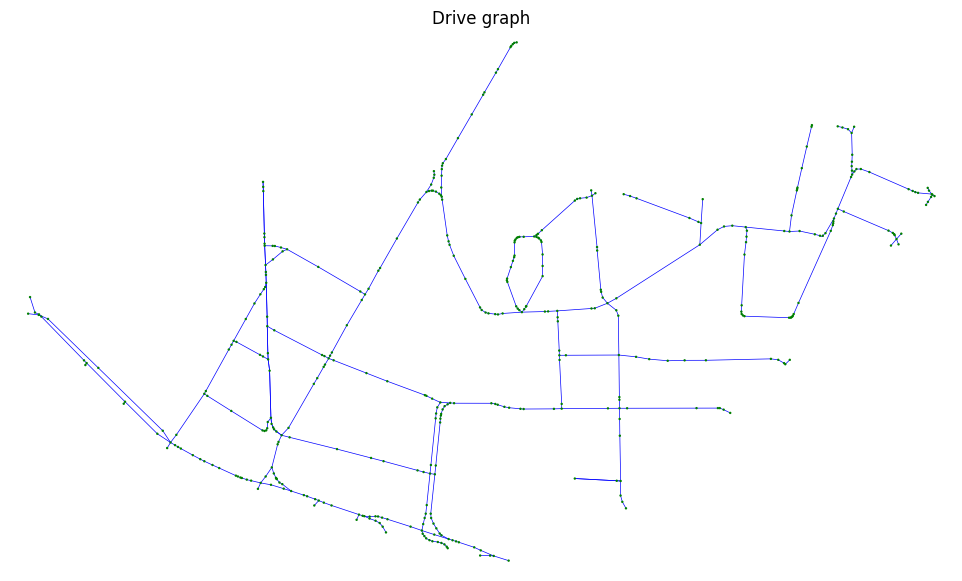

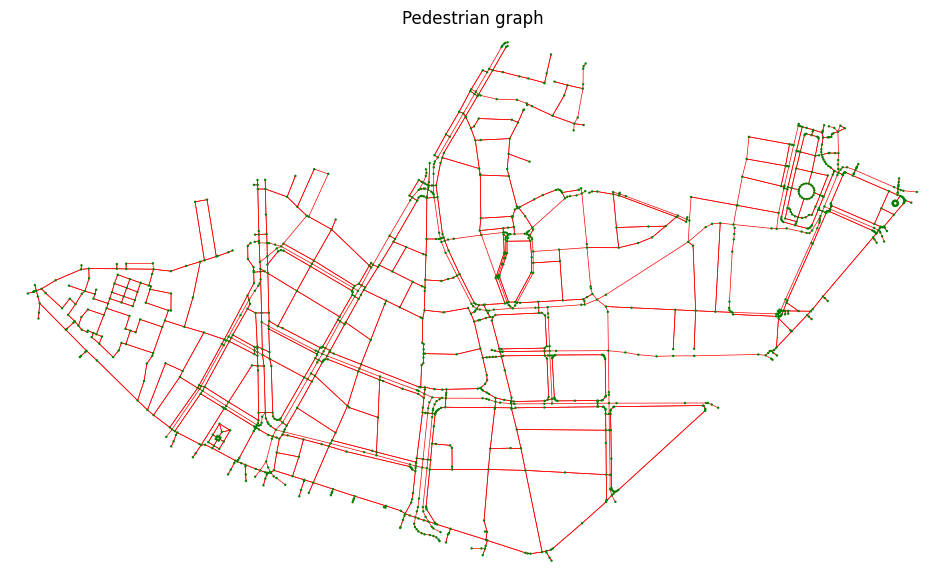

In [17]:
G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos= get_graph('SANT FRANCESC')
graph_map(G_drive, G_walk, shp_zone, shp_loading_points, shp_bajos)

## Supergraph building

In [32]:

# ==============================
# 1. Crear el supergrafo fusionando aristas
# ==============================

G_super = nx.MultiDiGraph()

# Agregar todos los nodos
G_super.add_nodes_from(G_drive.nodes(data=True))
G_super.add_nodes_from(G_walk.nodes(data=True))

# Función para añadir o fusionar aristas
def add_or_merge_edge(G, u, v, k, data, mode):
    data = data.copy()
    if 'mode' in data:
        current_mode = data['mode']
        if not isinstance(current_mode, list):
            data['mode'] = [current_mode]
    else:
        data['mode'] = []

    if mode not in data['mode']:
        data['mode'].append(mode)

    # Verifica si ya existe una arista idéntica en términos de u-v
    exists = False
    for key_existing in G[u][v] if G.has_edge(u, v) else []:
        existing_data = G[u][v][key_existing]
        if existing_data.get('geometry') == data.get('geometry'):
            # Fusionar modos
            if 'mode' in existing_data:
                for m in data['mode']:
                    if m not in existing_data['mode']:
                        existing_data['mode'].append(m)
            else:
                existing_data['mode'] = data['mode']
            exists = True
            break

    if not exists:
        G.add_edge(u, v, key=k, **data)

# Añadir aristas de G_drive
for u, v, k, data in G_drive.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'drive')

# Añadir aristas de G_walk
for u, v, k, data in G_walk.edges(keys=True, data=True):
    add_or_merge_edge(G_super, u, v, k, data, 'walk')
    if not G_walk.has_edge(v, u):
        add_or_merge_edge(G_super, v, u, k, data, 'walk')
    

# ==============================
# 2. Preparar k-d trees para búsquedas rápidas
# ==============================

G_drive_proj = ox.project_graph(G_drive)
G_walk_proj = ox.project_graph(G_walk)

nodes_drive = ox.graph_to_gdfs(G_drive_proj, edges=False)
nodes_walk = ox.graph_to_gdfs(G_walk_proj, edges=False)

coords_drive = np.vstack((nodes_drive['x'], nodes_drive['y'])).T
coords_walk = np.vstack((nodes_walk['x'], nodes_walk['y'])).T

kdtree_drive = cKDTree(coords_drive)
kdtree_walk = cKDTree(coords_walk)

index_to_node_drive = np.array(nodes_drive.index)
index_to_node_walk = np.array(nodes_walk.index)

project_geom = pyproj.Transformer.from_crs("EPSG:4326", nodes_drive.crs, always_xy=True).transform

# ==============================
# 3. Añadir nodos especiales
# ==============================

def add_special_node(G, geom, tipo, id_):
    nodo_id = f"{tipo}_{id_}"
    G.add_node(nodo_id, x=geom.centroid.x, y=geom.centroid.y, tipo=tipo)

    geom_proj = transform(project_geom, geom.centroid)
    x, y = geom_proj.x, geom_proj.y

    conexiones = []

    if tipo == "carga":
        # Conectar al nodo más cercano en drive
        dist_drive, idx_drive = kdtree_drive.query([x, y])
        nearest_drive = index_to_node_drive[idx_drive]
        conexiones.append((nearest_drive, 'drive', dist_drive))

        # Conectar al nodo más cercano en walk
        dist_walk, idx_walk = kdtree_walk.query([x, y])
        nearest_walk = index_to_node_walk[idx_walk]
        conexiones.append((nearest_walk, 'walk', dist_walk))
    
    else: # Almacén o Comercio
        # Solo se conecta a red peatonal
        dist, idx = kdtree_walk.query([x, y])
        nearest = index_to_node_walk[idx]
        conexiones.append((nearest, 'walk', dist))

    for nearest, modo, dist in conexiones:
        G.add_edge(nodo_id, nearest, mode=['connection', modo], length=dist)
        G.add_edge(nearest, nodo_id, mode=['connection', modo], length=dist)

    return nodo_id


# ==============================
# 4. Añadir todos los nodos especiales
# ==============================

nodos_carga = []
for i, row in shp_loading_points.iterrows():
    nodo = add_special_node(G_super, row.geometry, "carga", i)
    nodos_carga.append(nodo)

nodos_comercios = []
for i, row in shp_bajos[shp_bajos['Comercio'] == True].iterrows():
    nodo = add_special_node(G_super, row.geometry, "comercio", i)
    nodos_comercios.append(nodo)

nodos_almacenes = []
for i, row in shp_bajos[shp_bajos['Almacen'] == True].iterrows():
    nodo = add_special_node(G_super, row.geometry, "almacen", i)
    nodos_almacenes.append(nodo)

print(f"✅ Supergraph created with {len(G_super.nodes)} nodes and {len(G_super.edges)} edges.")


✅ Supergraph created with 1731 nodes and 4050 edges.


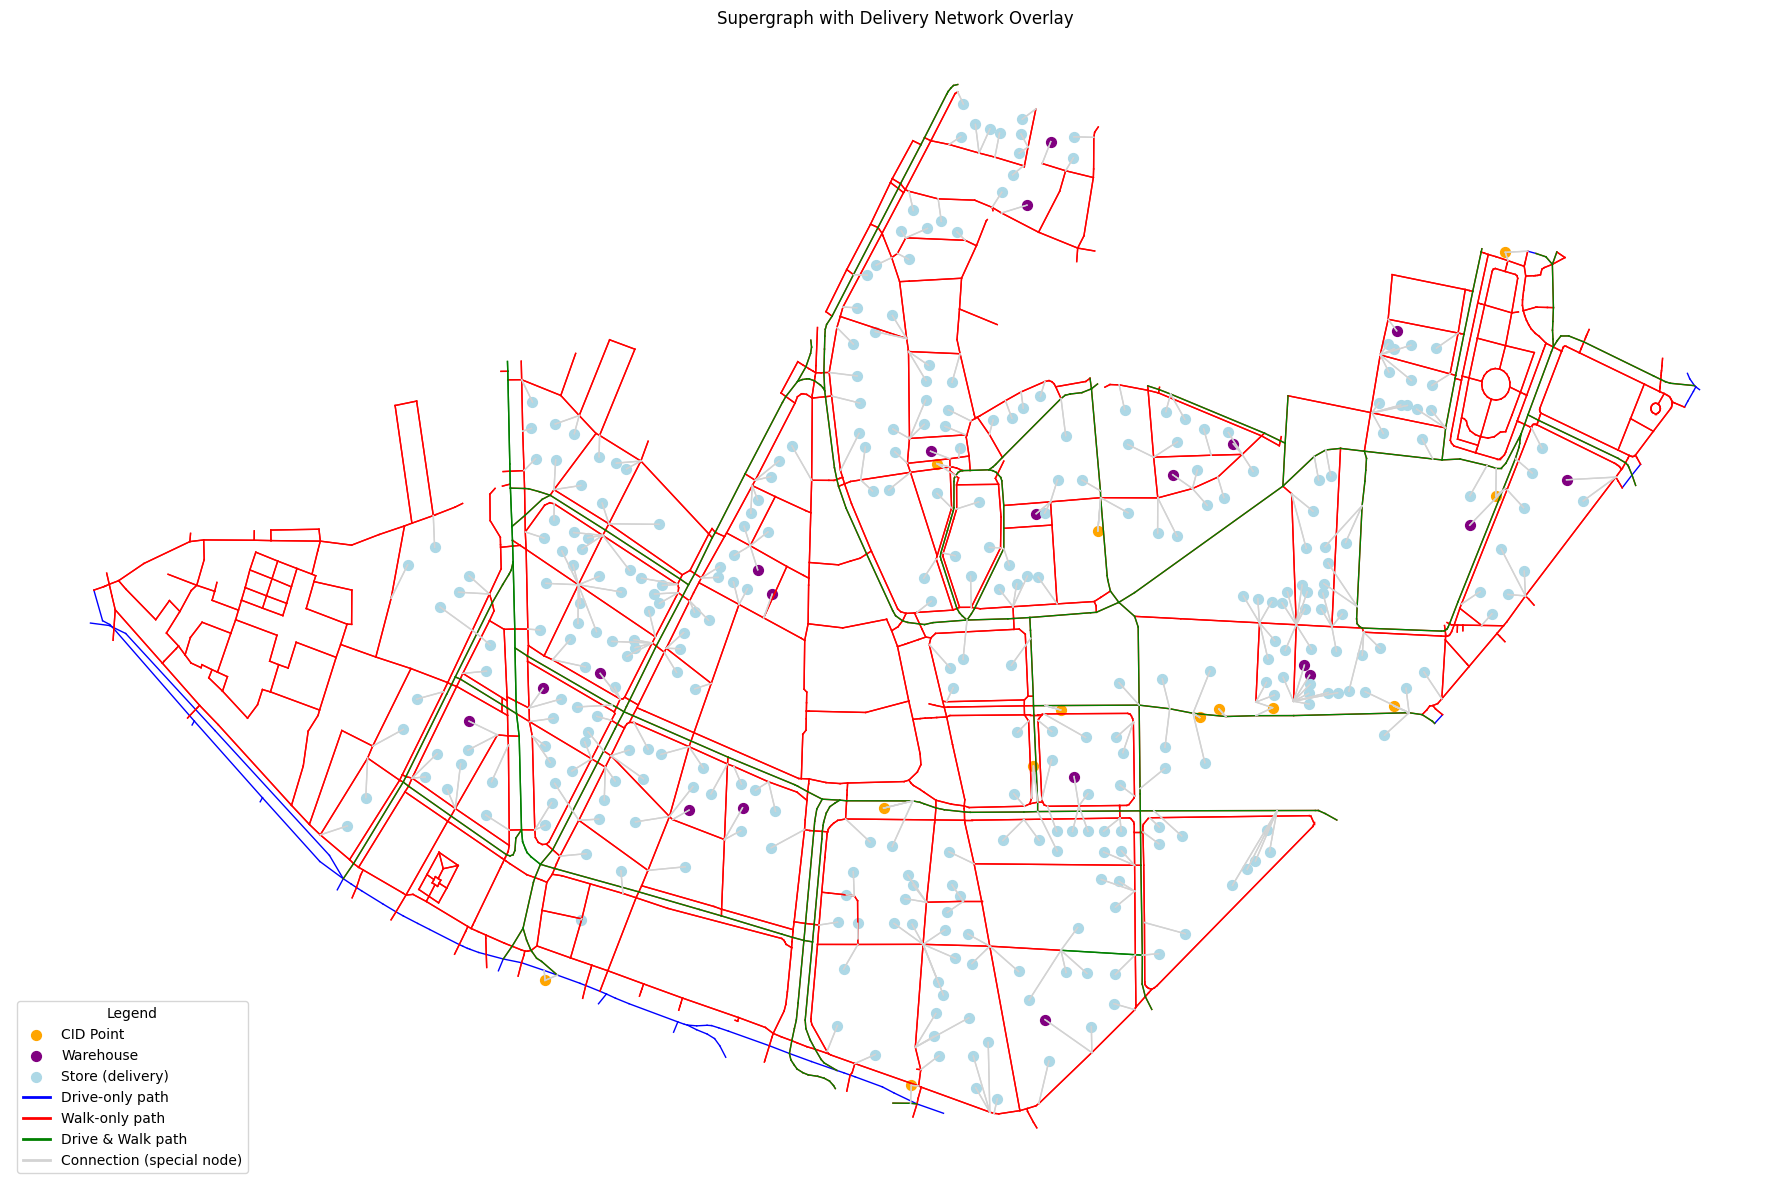

In [33]:

fig, ax = plt.subplots(figsize=(18, 12))

# ==========================
# 1. Pintar aristas por tipo
# ==========================

# Colores por modo
edge_colors = {
    'drive': 'blue',
    'walk': 'red',
    'drive+walk': 'green',
    'connection': 'lightgray'
}

# Organizar aristas por tipo (clave: modo, valor: lista de segmentos)
edges_by_mode = {k: [] for k in edge_colors}

for u, v, data in G_super.edges(data=True):
    mode = data.get('mode', 'connection')

    if isinstance(mode, list):
        if sorted(mode) == ['drive', 'walk']:
            mode_key = 'drive+walk'
        elif 'connection' in mode:
            mode_key = 'connection'
        elif 'drive' in mode:
            mode_key = 'drive'
        elif 'walk' in mode:
            mode_key = 'walk'
    else:
        mode_key = mode

    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    edges_by_mode[mode_key].append(([x0, x1], [y0, y1]))

# Pintar las líneas por modo
for mode_key, lines in edges_by_mode.items():
    for x_vals, y_vals in lines:
        ax.plot(x_vals, y_vals, color=edge_colors[mode_key], linewidth=1)

# ==========================
# 2. Pintar nodos según leyenda
# ==========================

categorias = {
    'cid': {'coords': [], 'color': 'orange', 'label': 'CID Point'},
    'almacen_m3': {'coords': [], 'color': 'purple', 'label': 'Warehouse'},
    'comercio_entrega': {'coords': [], 'color': 'lightblue', 'label': 'Store (delivery)'},
    'almacen_y_comercio': {'coords': [], 'color': 'black', 'label': 'Warehouse & Shop'},
}

for nodo, data in G_super.nodes(data=True):
    if isinstance(nodo, str):
        tipo = data.get('tipo')
        if tipo == 'carga':
            categorias['cid']['coords'].append((data['x'], data['y']))
        elif tipo == 'almacen' and 'comercio' in nodo:
            categorias['almacen_y_comercio']['coords'].append((data['x'], data['y']))
        elif tipo == 'almacen':
            categorias['almacen_m3']['coords'].append((data['x'], data['y']))
        elif tipo == 'comercio':
            categorias['comercio_entrega']['coords'].append((data['x'], data['y']))

# Pintar nodos especiales
for cat in categorias.values():
    if cat['coords']:
        xs, ys = zip(*cat['coords'])
        ax.scatter(xs, ys, color=cat['color'], s=50, label=cat['label'])

# ==========================
# 3. Añadir leyenda de aristas
# ==========================

edge_legend = [
    Line2D([0], [0], color='blue', lw=2, label='Drive-only path'),
    Line2D([0], [0], color='red', lw=2, label='Walk-only path'),
    Line2D([0], [0], color='green', lw=2, label='Drive & Walk path'),
    Line2D([0], [0], color='lightgray', lw=2, label='Connection (special node)'),
]

# ==========================
# 4. Estilo y leyenda
# ==========================

ax.set_title("Supergraph with Delivery Network Overlay")
ax.axis('off')

# Fusionar leyendas
handles_nodes, labels_nodes = ax.get_legend_handles_labels()
handles = handles_nodes + edge_legend
labels = labels_nodes + [h.get_label() for h in edge_legend]

# Eliminar duplicados
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower left', title='Legend')

plt.tight_layout()
plt.show()



## M1 Pipeline

### 0 Configuration

In [34]:
# ==============================
# CONFIGURACIÓN
# ==============================

N_PAQUETES = 40                # Número total de paquetes a repartir
PAQUETES_MIN = 1               # Mínimo de paquetes por comercio
PAQUETES_MAX = 5               # Máximo de paquetes por comercio
CAPACIDAD_MAXIMA = 8           # Capacidad máxima que puede cargar el repartidor
VELOCIDAD_VEHICULO = 35        # Velocidad de la furgoneta en km/h si no hay en la arista max_speed
VELOCIDAD_PEATON = 5           # Velocidad del repartidor a pie en km/h
VELOCIDAD_CONEXION = 10        # Velocidad de las aristas de conexión en modo drive km/h


### 1 Deliveries sample

In [35]:
# ==============================
# Seleccionar comercios y asignar paquetes
# ==============================

paquetes_asignados = 0
bajos_seleccionados = []
paquetes_por_nodo = []

comercios_disponibles = nodos_comercios.copy()
random.shuffle(comercios_disponibles)

while paquetes_asignados < N_PAQUETES and comercios_disponibles:
    nodo = comercios_disponibles.pop()
    paquetes_restantes = N_PAQUETES - paquetes_asignados
    paquetes_maximos_posibles = min(PAQUETES_MAX, paquetes_restantes)

    if paquetes_maximos_posibles < PAQUETES_MIN:
        break  # No se puede asignar el mínimo a un nuevo comercio

    paquetes = random.randint(PAQUETES_MIN, paquetes_maximos_posibles)
    bajos_seleccionados.append(nodo)
    paquetes_por_nodo.append(paquetes)
    paquetes_asignados += paquetes

# Crear GeoDataFrame con los comercios seleccionados y sus paquetes
df = pd.DataFrame([{'nodo': n, **G_super.nodes[n]} for n in bajos_seleccionados])
bajos_sample = gpd.GeoDataFrame(df, geometry=[Point(row['x'], row['y']) for _, row in df.iterrows()], crs="EPSG:4326")
bajos_sample['paquetes'] = paquetes_por_nodo
display(bajos_sample)



nodo         x          y      tipo                   geometry  \
0   comercio_19625 -0.375460  39.467829  comercio  POINT (-0.37546 39.46783)   
1   comercio_21116 -0.373226  39.470047  comercio  POINT (-0.37323 39.47005)   
2   comercio_20356 -0.374357  39.469263  comercio  POINT (-0.37436 39.46926)   
3   comercio_15846 -0.380185  39.470551  comercio  POINT (-0.38019 39.47055)   
4   comercio_21891 -0.371245  39.470042  comercio  POINT (-0.37125 39.47004)   
5   comercio_17099 -0.378627  39.470140  comercio  POINT (-0.37863 39.47014)   
6   comercio_19665 -0.375633  39.470067  comercio  POINT (-0.37563 39.47007)   
7   comercio_18772 -0.376496  39.472369  comercio   POINT (-0.3765 39.47237)   
8   comercio_19650 -0.375977  39.468681  comercio  POINT (-0.37598 39.46868)   
9   comercio_19635 -0.375695  39.467977  comercio   POINT (-0.3757 39.46798)   
10  comercio_18752 -0.377479  39.471055  comercio  POINT (-0.37748 39.47106)   
11  comercio_17674 -0.378430  39.469548  comercio  POINT (-0.37843 39.46955)   
12  comercio_21106 -0.372882  39.468779  comercio  POINT (-0.37288 39.46878)   
13  comercio_19725 -0.374993  39.473358  comercio  POINT (-0.37499 39.47336)   

    paquetes  
0          5  
1          3  
2          3  
3          2  
4          1  
5          5  
6          3  
7          4  
8          5  
9          2  
10         2  
11         1  
12         1  
13         3

### 2 Clusters

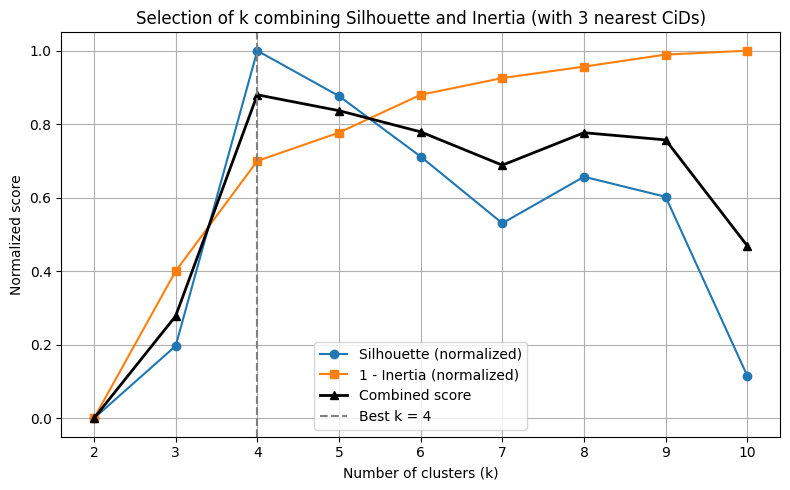

✅ Deliveries assigned to 4 couriers (using coordinates of the 3 nearest CiDs).


In [36]:
# ==============================
# Assign the 3 nearest loading points (CiDs)
# ==============================

k_cids = min(3, len(nodos_carga))  # number of nearest CiDs to include
carga_coords = np.array([(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in nodos_carga])
tree_cid = cKDTree(carga_coords)

entrega_coords = np.array([(geom.y, geom.x) for geom in bajos_sample.geometry])
distances, indices = tree_cid.query(entrega_coords, k=k_cids)

# ==============================
# Create features: commerce coords + coords of 3 nearest CiDs
# ==============================

features = []
for i, row in bajos_sample.iterrows():
    x_c, y_c = row.geometry.x, row.geometry.y
    vector = [x_c, y_c]

    for j in range(k_cids):
        cid_idx = indices[i][j]
        cid_node = nodos_carga[cid_idx]
        x_d = G_super.nodes[cid_node]['x']
        y_d = G_super.nodes[cid_node]['y']
        vector.extend([x_d, y_d])

    features.append(vector)

features = np.array(features)

# ==============================
# Clustering evaluated using Silhouette + Inertia
# ==============================

def estimate_best_k(features, k_min=2, k_max=10, alpha=0.5):
    silhouette_scores = []
    inertias = []
    ks = []

    for k in range(k_min, min(k_max + 1, len(features))):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(features)

        try:
            silhouette = silhouette_score(features, labels)
        except:
            silhouette = -1

        inertia = kmeans.inertia_
        ks.append(k)
        silhouette_scores.append(silhouette)
        inertias.append(inertia)

    # Normalize both metrics
    scaler = MinMaxScaler()
    sil_norm = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()
    ine_norm = scaler.fit_transform(np.array(inertias).reshape(-1, 1)).flatten()
    ine_norm = 1 - ine_norm  # lower inertia is better

    combined = alpha * sil_norm + (1 - alpha) * ine_norm
    best_idx = np.argmax(combined)
    best_k = ks[best_idx]

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ks, sil_norm, label='Silhouette (normalized)', marker='o')
    ax.plot(ks, ine_norm, label='1 - Inertia (normalized)', marker='s')
    ax.plot(ks, combined, label='Combined score', marker='^', linewidth=2, color='black')
    ax.axvline(x=best_k, color='gray', linestyle='--', label=f'Best k = {best_k}')
    ax.set_xlabel("Number of clusters (k)")
    ax.set_ylabel("Normalized score")
    ax.set_title("Selection of k combining Silhouette and Inertia (with 3 nearest CiDs)")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

    return best_k

# Estimate optimal k and apply clustering
N_REPARTIDORES = estimate_best_k(features, k_min=2, k_max=10, alpha=0.6)
kmeans = KMeans(n_clusters=N_REPARTIDORES, random_state=42)
bajos_sample['grupo_repartidor'] = kmeans.fit_predict(features) + 1

print(f"✅ Deliveries assigned to {N_REPARTIDORES} couriers (using coordinates of the {k_cids} nearest CiDs).")


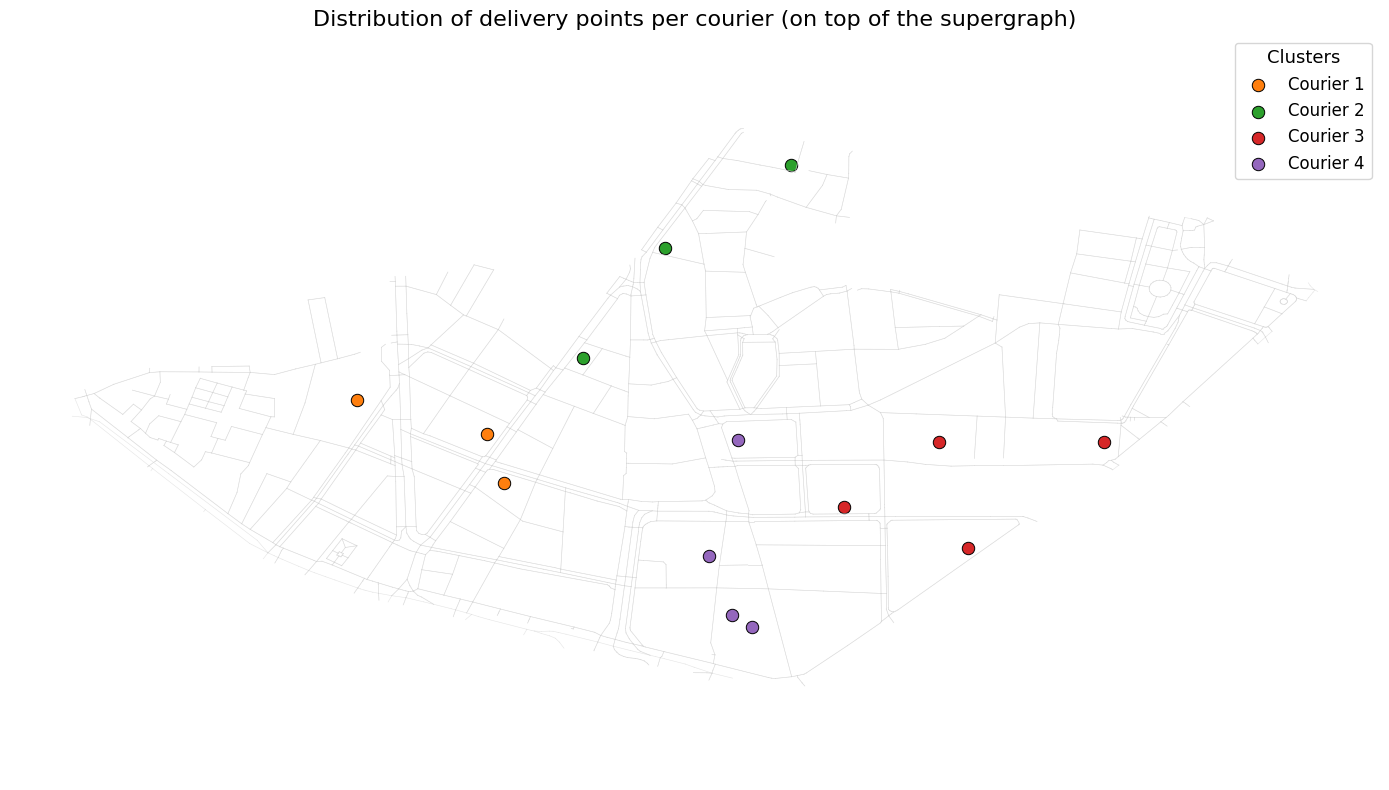

In [37]:
# ==============================
# Visualize G_super + delivery points by cluster
# ==============================

fig, ax = plt.subplots(figsize=(14, 8))

# 1. Draw the edges of the supergraph (all streets)
for u, v, data in G_super.edges(data=True):
    if isinstance(u, str) or isinstance(v, str):
        continue
    x0, y0 = G_super.nodes[u]['x'], G_super.nodes[u]['y']
    x1, y1 = G_super.nodes[v]['x'], G_super.nodes[v]['y']
    ax.plot([x0, x1], [y0, y1], color='lightgray', linewidth=0.4, alpha=0.6)

# 2. Plot delivery points grouped by cluster
colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

for group in sorted(bajos_sample['grupo_repartidor'].unique()):
    group_deliveries = bajos_sample[bajos_sample['grupo_repartidor'] == group]
    xs = group_deliveries.geometry.x
    ys = group_deliveries.geometry.y
    ax.scatter(xs, ys, label=f'Courier {group}', s=80, color=colors[group % len(colors)], edgecolor='black', linewidth=0.7)

# 3. General plot style
ax.set_title("Distribution of delivery points per courier (on top of the supergraph)", fontsize=16)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
ax.axis('off')
ax.legend(title="Clusters", fontsize=12, title_fontsize=13)

plt.tight_layout()
plt.show()


### 3 Routing

In [38]:
# ==============================
# 1. FUNCIONES DE TIEMPO
# ==============================
def tiempo_por_distancia(distancia_metros, velocidad_kmh):
    """Convierte distancia en metros y velocidad en km/h a tiempo en minutos."""
    return distancia_metros / (velocidad_kmh * 1000 / 60)

def calcular_tiempos_en_aristas(G, VELOCIDAD_PEATON=5, VELOCIDAD_VEHICULO=35, VELOCIDAD_CONNECTION=10):
    """
    Añade a cada arista del grafo G los tiempos de caminata (tiempo_walk)
    y de conducción (tiempo_drive) según su modo ('walk','drive','connection').
    """
    for u, v, k, data in G.edges(keys=True, data=True):
        d     = data.get('length', 100)
        modos = data.get('mode', ['walk'])
        if 'connection' in modos:
            data['tiempo_walk']  = tiempo_por_distancia(d, VELOCIDAD_PEATON)
            data['tiempo_drive'] = tiempo_por_distancia(d, VELOCIDAD_CONNECTION)
            continue
        if 'walk' in modos:
            data['tiempo_walk'] = tiempo_por_distancia(d, VELOCIDAD_PEATON)
        if 'drive' in modos:
            v_kmh = data.get('maxspeed', VELOCIDAD_VEHICULO)
            if isinstance(v_kmh, str):
                v_kmh = int(''.join(filter(str.isdigit, v_kmh)) or VELOCIDAD_VEHICULO)
            data['tiempo_drive'] = tiempo_por_distancia(d, v_kmh)
        data.setdefault('tiempo_walk',  float('inf'))
        data.setdefault('tiempo_drive', float('inf'))

def calcular_tiempo_drive(origen, destino):
    """Ruta más rápida en vehículo entre origen y destino (minutos)."""
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_drive')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed    = G_super.get_edge_data(u, v)
        t_min = min(e['tiempo_drive'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

def calcular_tiempo_walk(origen, destino):
    """Ruta más rápida a pie entre origen y destino (minutos)."""
    try:
        camino = nx.shortest_path(G_super, origen, destino, weight='tiempo_walk')
    except nx.NetworkXNoPath:
        return float('inf'), None
    tiempo = 0.0
    for u, v in zip(camino[:-1], camino[1:]):
        ed    = G_super.get_edge_data(u, v)
        t_min = min(e['tiempo_walk'] for e in ed.values())
        tiempo += t_min
    return tiempo, camino

# ==============================
# 2. FUNCIONES AUXILIARES
# ==============================
def obtener_centroide_grupo(df_grupo):
    """Centroide geográfico de un DataFrame de geometrías."""
    return df_grupo.geometry.union_all().centroid

def distancia_euclidea(x1, y1, x2, y2):
    """Distancia euclídea en 2D."""
    return np.hypot(x1 - x2, y1 - y2)

def nodo_cid_mas_cercano(geom, nodos_cid):
    """Nodo CiD más cercano por distancia euclídea."""
    coords = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in nodos_cid]
    tree   = cKDTree(coords)
    _, idx = tree.query((geom.y, geom.x))
    return nodos_cid[idx]

def calcular_matriz_distancias(pendientes, nodo_cid):
    """
    Matriz de distancias a pie entre todos los nodos pendientes + nodo CiD.
    """
    distancias = {}
    puntos     = pendientes['nodo'].tolist() + [nodo_cid]
    for n1 in puntos:
        distancias[n1] = {}
        for n2 in puntos:
            if n1 == n2:
                continue
            t, _ = calcular_tiempo_walk(n1, n2)
            distancias[n1][n2] = t
    return distancias

# ==============================
# 3. INICIALIZACIÓN
# ==============================
calcular_tiempos_en_aristas(G_super)

rutas_y_tiempos   = []
inicios_furgoneta = []
grupos_pendientes = set(bajos_sample['grupo_repartidor'].unique())
centroides_grupos = {
    g: obtener_centroide_grupo(bajos_sample[bajos_sample['grupo_repartidor']==g])
    for g in grupos_pendientes
}

# parámetro inicial para node-boundary
thresh = 0.00005

# contadores globales
tiempo_total_total = tiempo_drive_total = tiempo_walk_total = 0.0

# ==============================
# 4. RECORRIDO POR CADA CLÚSTER
# ==============================
while grupos_pendientes:
    # recalcular boundary_nodes con el umbral actual
    boundary_nodes = [
        n for n,d in G_drive.nodes(data=True)
        if shp_zone.boundary.distance(Point(d['x'], d['y'])) < thresh
    ]
    if not boundary_nodes or len(boundary_nodes) < 5:
        if thresh < 0.1:
            thresh = min(thresh * 3, 0.1)
            continue
        else:
            raise RuntimeError("No se encontró entrada válida para los clústeres restantes.")
        
    random.shuffle(boundary_nodes)

    # intentar encontrar entrada válida; si falla, aumentar thresh hasta 0.05
    entry_info = None
    for bnd in boundary_nodes:
        # elegir clúster más cercano por euclídea
        g_cand = min(
            grupos_pendientes,
            key=lambda g: distancia_euclidea(
                G_super.nodes[bnd]['x'], G_super.nodes[bnd]['y'],
                centroides_grupos[g].x, centroides_grupos[g].y
            )
        )
        cid_cand = nodo_cid_mas_cercano(centroides_grupos[g_cand], nodos_carga)
        t_drive, camino = calcular_tiempo_drive(bnd, cid_cand)
        if camino and np.isfinite(t_drive):
            entry_info = (bnd, g_cand, cid_cand, camino[1:], t_drive)
            break

    if entry_info is None:
        # si no encontramos y aún podemos aumentar thresh
        if thresh < 0.1:
            thresh = min(thresh * 3, 0.1)
            continue
        else:
            raise RuntimeError("No se encontró entrada válida para los clústeres restantes.")

    # desempaquetar entrada válida
    entry, grupo_sel, nodo_cid, ruta_drive, tiempo_drive = entry_info
    inicios_furgoneta.append(entry)
    tiempo_drive_total += tiempo_drive

    # preparativos para entregas a pie
    sub_bajos  = bajos_sample[bajos_sample['grupo_repartidor']==grupo_sel]
    pendientes = sub_bajos.copy()
    nodo_actual = nodo_cid
    carga_actual = 0
    rutas_walk   = []
    tiempos_walk = []
    tiempo_walk_cluster = 0.0

    matriz_dist = calcular_matriz_distancias(pendientes, nodo_cid)

    # nearest‐neighbor greedy + recarga
    while not pendientes.empty:
        dist_map = { n: matriz_dist[nodo_actual][n] for n in pendientes['nodo'] }
        nodo_sig = min(dist_map, key=dist_map.get)
        pkgs     = pendientes.loc[pendientes['nodo']==nodo_sig, 'paquetes'].item()

        # recargar si excede capacidad
        if carga_actual + pkgs > CAPACIDAD_MAXIMA:
            t_back, camino_back = calcular_tiempo_walk(nodo_actual, nodo_cid)
            dist_back = sum(
                G_super.get_edge_data(u,v)[0]['length']
                for u,v in zip(camino_back[:-1], camino_back[1:])
            )
            tiempo_walk_cluster += tiempo_por_distancia(dist_back, VELOCIDAD_PEATON)
            nodo_actual = nodo_cid
            carga_actual = 0
            continue

        # entrega
        t_ida, camino_ida = calcular_tiempo_walk(nodo_actual, nodo_sig)
        dist_ida = sum(
            G_super.get_edge_data(u,v)[0]['length']
            for u,v in zip(camino_ida[:-1], camino_ida[1:])
        )
        t_walk = tiempo_por_distancia(dist_ida, VELOCIDAD_PEATON)

        tiempo_walk_cluster += t_walk
        rutas_walk.append(camino_ida[1:])
        tiempos_walk.append(t_walk)

        carga_actual += pkgs
        pendientes = pendientes[pendientes['nodo']!=nodo_sig]
        nodo_actual = nodo_sig

        # ruta de vuelta (opcional)
        '''
        HAY QUE DARLE UN OJO A ESTO
        '''
        tiempo_walk_cluster += t_walk
        rutas_walk.append(list(reversed(camino_ida))[1:])
        tiempos_walk.append(t_walk)

    # almacenar resultados
    rutas_y_tiempos.append({
        'grupo_repartidor': grupo_sel,
        'ruta_furgoneta':   ruta_drive,
        'tiempo_drive':     tiempo_drive,
        'tiempo_walk':      tiempo_walk_cluster,
        'rutas_walk':       rutas_walk,
        'tiempos_walk':     tiempos_walk
    })

    tiempo_total_total += tiempo_drive + tiempo_walk_cluster
    tiempo_walk_total  += tiempo_walk_cluster
    grupos_pendientes.remove(grupo_sel)

# ==============================
# 5. RESULTADOS FINALES
# ==============================
df_rutas_y_tiempos = pd.DataFrame(rutas_y_tiempos)

print(f"⏱️ Total delivery time: {tiempo_total_total:.1f} min")
print(f"🚐 Total driving time: {tiempo_drive_total:.1f} min")
print(f"🚶‍♂️ Total walking time: {tiempo_walk_total:.1f} min\n")
print("Details by cluster:")
display(df_rutas_y_tiempos)


⏱️ Total delivery time: 84.8 min
🚐 Total driving time: 3.1 min
🚶‍♂️ Total walking time: 81.6 min

Details by cluster:


grupo_repartidor                                     ruta_furgoneta  \
0                 2  [55597254, 7515834822, 11918521173, 7515834823...   
1                 3  [25767364, 7596340186, 1828089465, 10587000413...   
2                 1  [29935873, 10960344714, 33214677, 12386899231,...   
3                 4  [29935873, 10960344714, 33214677, 12386899231,...   

   tiempo_drive  tiempo_walk  \
0      0.312160    21.743129   
1      0.399197    24.100406   
2      1.388219    14.203211   
3      1.016092    21.594867   

                                          rutas_walk  \
0  [[11918521157, 25767324, 1083021628, 57472064,...   
1  [[314767827, 35594389, comercio_21116], [35594...   
2  [[4682062491, 7616002240, 4682062490, 60886383...   
3  [[8207186984, 11420770030, 8207186986, 3485355...   

                                        tiempos_walk  
0  [2.5367227991800276, 2.5367227991800276, 2.322...  
1  [0.8005025192129355, 0.8005025192129355, 2.583...  
2  [2.960815449384997, 2.960815449384997, 1.39670...  
3  [1.522044902326264, 1.522044902326264, 1.02983...

In [39]:
# Mostrar el orden de los grupos de entrega, tiempos y detalle de comercios visitados
print("\n📦  DELIVERY SUMMARY  📦")
print("=" * 65)

for idx, row in df_rutas_y_tiempos.iterrows():
    grupo        = row['grupo_repartidor']
    tiempo_drive = row['tiempo_drive']
    tiempo_walk  = row['tiempo_walk']
    rutas_walk   = row['rutas_walk']
    tiempos_walk = row['tiempos_walk']

    # Encabezado de clúster
    print(f"\n🚚  CLUSTER {grupo}")
    print(f"• Drive time : {tiempo_drive:6.2f} min")
    print(f"• Walk time  : {tiempo_walk:6.2f} min")

    # Preparamos la secuencia de entregas (solo los tramos de ida)
    entregas_paths = rutas_walk[0::2]

    # Imprimimos la tabla con tiempos de llegada
    print("\n   📍  Delivery sequence:")
    print("     No. |       Node        | Packages | Arrival (min)")
    print("     ----+-------------------+----------+---------------")

    cumulative_walk = 0.0
    for i, path in enumerate(entregas_paths, start=1):
        comercio = path[-1]
        pkgs     = bajos_sample.loc[bajos_sample['nodo']==comercio, 'paquetes'].iat[0]

        # El índice en tiempos_walk para el tramo de ida es (i-1)*2
        idx_walk = (i - 1) * 2
        t_ida    = tiempos_walk[idx_walk]
        cumulative_walk += t_ida

        # Tiempo de llegada = tiempo de drive + tiempo acumulado de walk
        arrival_time = tiempo_drive + cumulative_walk

        print(f"     {i:>3}  | {comercio:<17} | {pkgs:^8} | {arrival_time:>13.2f}")

    print("-" * 65)





📦  DELIVERY SUMMARY  📦

🚚  CLUSTER 2
• Drive time :   0.31 min
• Walk time  :  21.74 min

   📍  Delivery sequence:
     No. |       Node        | Packages | Arrival (min)
     ----+-------------------+----------+---------------
       1  | comercio_18772    |    4     |          2.85
       2  | comercio_18752    |    2     |          5.17
       3  | comercio_19725    |    3     |          9.87
-----------------------------------------------------------------

🚚  CLUSTER 3
• Drive time :   0.40 min
• Walk time  :  24.10 min

   📍  Delivery sequence:
     No. |       Node        | Packages | Arrival (min)
     ----+-------------------+----------+---------------
       1  | comercio_21116    |    3     |          1.20
       2  | comercio_20356    |    3     |          3.78
       3  | comercio_21106    |    1     |          6.43
       4  | comercio_21891    |    1     |         12.45
-----------------------------------------------------------------

🚚  CLUSTER 1
• Drive time :   1.39

### 4 Results mapping

In [41]:
# ==============================
# 1. COLORES POR CLÚSTER
# ==============================
cluster_ids    = sorted(bajos_sample['grupo_repartidor'].unique())
base_colors    = list(mcolors.TABLEAU_COLORS.values())
cluster_colors = {cid: base_colors[i % len(base_colors)] for i, cid in enumerate(cluster_ids)}

# ==============================
# (Re)compute order_map
# ==============================
order_map = {}
for _, row in df_rutas_y_tiempos.iterrows():
    grp        = row['grupo_repartidor']
    rutas_walk = row['rutas_walk']
    entregas   = rutas_walk[0::2]
    order_map[grp] = { path[-1]: idx+1 for idx, path in enumerate(entregas) }

# ==============================
# 2. PREPARAR MARCADORES AGRUPADOS
# ==============================
items = []
for nodo, data in G_super.nodes(data=True):
    if nodo in set(bajos_sample['nodo']):
        grp   = bajos_sample.loc[bajos_sample['nodo']==nodo, 'grupo_repartidor'].iat[0]
        pkgs  = bajos_sample.loc[bajos_sample['nodo']==nodo, 'paquetes'].iat[0]
        order = order_map[grp].get(nodo)  # now defined
        items.append((data['y'], data['x'], 'comercio', nodo, grp, pkgs, order))

cluster_to_cid = {
    row['grupo_repartidor']: row['ruta_furgoneta'][-1]
    for _, row in df_rutas_y_tiempos.iterrows() if row['ruta_furgoneta']
}
for grp, cid in cluster_to_cid.items():
    y, x = G_super.nodes[cid]['y'], G_super.nodes[cid]['x']
    items.append((y, x, 'cid', cid, grp, None, None))

loc_groups = defaultdict(list)
for it in items:
    loc = (round(it[0], 6), round(it[1], 6))
    loc_groups[loc].append(it)

# ==============================
# 3. CREAR MAPA
# ==============================
centro_mapa = [
    np.mean([d['y'] for _, d in G_super.nodes(data=True)]),
    np.mean([d['x'] for _, d in G_super.nodes(data=True)])
]
m = folium.Map(location=centro_mapa, zoom_start=16, tiles="cartodb positron")
GeoJson(
    shp_zone,
    style_function=lambda f: {"color":"green","weight":6,"fill":True,"fillColor":"limegreen","fillOpacity":0.1}
).add_to(m)

# ==============================
# 4. MARCAR NODOS Y CÍRCULOS DE GRUPO
# ==============================
RADIUS_METERS = 7
for (lat0, lon0), group in loc_groups.items():
    n = len(group)
    if n > 1:
        folium.Circle(
            location=(lat0, lon0),
            radius=RADIUS_METERS,
            color="black", weight=1,
            fill=True, fill_color="black", fill_opacity=0.2
        ).add_to(m)
    for idx, (lat, lon, tipo, nodo, grp, pkgs, order) in enumerate(group):
        color = cluster_colors[grp]
        if n == 1:
            lat_j, lon_j = lat, lon
        else:
            angle = 2 * math.pi * idx / n
            dlat  = (RADIUS_METERS * math.cos(angle)) / 111000
            dlon  = (RADIUS_METERS * math.sin(angle)) / (111000 * math.cos(math.radians(lat0)))
            lat_j, lon_j = lat0 + dlat, lon0 + dlon

        if tipo == 'comercio':
            CircleMarker(
                location=(lat_j, lon_j), radius=8,
                color=color, fill=True, fill_opacity=0.7
            ).add_to(m)
            if order:
                Marker(
                    location=(lat_j, lon_j),
                    icon=DivIcon(
                        icon_size=(20,20),
                        html=(
                            f"<div style='font-size:12px;color:white;"
                            f"background:{color};border-radius:50%;"
                            f"width:20px;height:20px;line-height:20px;text-align:center;'>"
                            f"{order}</div>"
                        )
                    )
                ).add_to(m)
        else:  # CiD
            Marker(
                location=(lat_j, lon_j),
                icon=Icon(color="white", icon_color=color, icon="truck", prefix="fa"),
                popup=f"CiD Cluster {grp}"
            ).add_to(m)

# ==============================
# 5. RUTAS Y PUNTOS DE ENTRADA CON CLUSTERING
# ==============================
entry_cluster = MarkerCluster(name="Truck start points").add_to(m)

for _, row in df_rutas_y_tiempos.iterrows():
    grp        = row['grupo_repartidor']
    color      = cluster_colors[grp]
    ruta_drive = row['ruta_furgoneta']

    # 5.1 – Inicio furgoneta
    if ruta_drive:
        inicio = ruta_drive[0]
        y0, x0 = G_super.nodes[inicio]['y'], G_super.nodes[inicio]['x']
        Marker(
            location=(y0, x0),
            icon=DivIcon(
                icon_size=(25,25),
                html=(
                    f"<div style='"
                    f"width:25px;height:25px;"
                    f"background:{color};"
                    f"border:3px solid black;"        # <-- black circumference
                    f"border-radius:50%;"
                    f"display:flex;align-items:center;"
                    f"justify-content:center;"
                    f"color:#fff;font-weight:bold;"
                    f"font-size:14px;"
                    f"'>"
                    f"{grp}"
                    f"</div>"
                )
            ),
            popup=f"Truck start for cluster {grp}"
        ).add_to(entry_cluster)

    # 5.2 – Línea furgoneta
    coords_d = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in ruta_drive]
    if coords_d:
        PolyLine(coords_d, color=color, weight=4, opacity=0.7).add_to(m)

    # 5.3 – Caminata
    for caminata in row['rutas_walk']:
        coords_w = [(G_super.nodes[n]['y'], G_super.nodes[n]['x']) for n in caminata]
        PolyLine(coords_w, color=color, weight=2, opacity=0.9, dash_array="2,8").add_to(m)

# ==============================
# 6. MOSTRAR MAPA
# ==============================
m
